In [ ]:
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


#General Functions

In [ ]:
def normalizeData(arr):
    arr_mean = arr.mean(axis=0)
    arr_std = arr.std(axis=0)
    return (arr - arr_mean) / arr_std

In [ ]:
def importMNIST():
  images_array = np.load("/content/drive/My Drive/PRNN_assignment_1/kmnist-train-imgs.npz")['arr_0']
  print(images_array.shape)
  X_train=images_array
  # flattened_images = images_array.reshape(images_array.shape[0], -1).T
  # X_train = flattened_images.astype(np.float64)
  X_train = X_train/255

  images_array = np.load("/content/drive/My Drive/PRNN_assignment_1/kmnist-test-imgs.npz")['arr_0']
  X_test=images_array
  # flattened_images = images_array.reshape(images_array.shape[0], -1).T
  # X_test = flattened_images.astype(np.float64)
  X_test = X_test/255

  data = np.load("/content/drive/My Drive/PRNN_assignment_1/kmnist-train-labels.npz")
  y_train = data['arr_0']
  data.close()

  data = np.load("/content/drive/My Drive/PRNN_assignment_1/kmnist-test-labels.npz")
  y_test = data['arr_0']
  data.close()
  return X_train,y_train,X_test,y_test


In [ ]:
def plotTradeoff(test,train,mul=10):
  n=len(test)
  epoch=[(i+1)*mul for i in range(n)]
  plt.plot(epoch,test,label="test")
  plt.plot(epoch,train,label="train")
  plt.legend()
  plt.show()

In [ ]:
def splitTrainTest(data,train_ratio,data_freature):
  test_ratio=1-train_ratio
  np.random.shuffle(data)
  num_samples = len(data)
  num_train = int(train_ratio * num_samples)
  num_test = int(test_ratio * num_samples)
  train_data = data[:num_train]
  test_data = data[num_train:]
  X_train = train_data[:, 0:data_freature]
  y_train = train_data[:, data_freature:]
  X_test = test_data[:, 0:data_freature]
  y_test = test_data[:, data_freature:]
  float_array = np.array(y_test)
  return X_train,y_train,X_test,y_test

In [ ]:
def oneHotConvert(y,classes):
  y=y.astype(int)
  encoded_output = np.zeros((len(y), classes))
  for i in range(len(y)):
    encoded_output[i][y[i]]=1

  return encoded_output

In [ ]:
def softmaxOneHotConvert(y,num_classes):
  row,col=y.shape
  encoded_output = np.zeros((row,col))
  # encoded_output=encoded_output.T
  # print(encoded_output.shape)
  # row,col=y.shape
  for i in range(col):
    idx=0
    for j in range(1,row):
      print(j,i)
      if y[j][i] > y[idx][i]:
        idx=j
    encoded_output[idx][i]=1
  return encoded_output

MLP class

In [ ]:
class neuralNetwork:
  #construction
  def __init__(self,layer_sizes,activation_fun='sigmoid',loss_fun='MSE',alpha=0.0,output_type='R',regulization_type='L2'):
    #layers_size = size of each layer i. number of neuron in each layer input and output layer included
    # print(type(alpha))
    self.alpha=alpha
    self.output_type=output_type
    self.layer_sizes = layer_sizes
    self.weights = [np.sqrt(1./output)*np.random.rand(output,input) for input,output in zip(layer_sizes[:-1],layer_sizes[1:])]
    # randomly initlize weight for all layer (in matrix form) from normal distrubution
    # divide by 1/sqrt(output) so that all weight close so that grad vanishing and exploding problem does not occur
    self.biases = [np.random.randn(y, 1) for y in layer_sizes[1:]] #as input layer does not have bias


    if activation_fun == 'sigmoid':
      self.activation_fun=self.sigmoid
    else:
      self.activation_fun=self.relu   #assigning activation_function


    if loss_fun =='MSE':
       self.loss_fun=self.MSE
    elif loss_fun=="CE" or loss_fun=="ce":
       self.loss_fun=self.crossEntropy

    if  regulization_type=='L2':
      self.regulization_type='L2'
    elif regulization_type=='L1':
      self.regulization_type='L1'
    elif regulization_type=='both':
      self.regulization_type='both'

  def forwardPass(self,X):
    activations =[X]    # Store input as the first activation
    z_value =[X]
    # Note:- X is matrix i.e. all multiple data point is present with dimension (freature,data_point) for multiplication
    # activations store all value that we activate at each layer output i.e activation_function(W.X +b)
    # flag=0
    for w,b in zip(self.weights,self.biases):
      # print("w.shaoe= ",w.shape," activations[-1].shape =  ",activations[-1].shape)
      # print("-----------------------------------------------------------------------------------------------------------------------------")
      z=w@activations[-1] + b
      a=self.activation_fun(z)
      z_value.append(z)
      activations.append(a)

    if self.output_type=='C' or self.output_type=='c':
      activations[-1]=self.softmax(z_value[-1])

    elif self.output_type=='R' or self.output_type=='r':
      activations[-1]=z_value[-1]

    return z_value,activations

  def backwardPass(self,X,y):
    z_value,activations=self.forwardPass(X)
    grads=[]
    grads.append(self.loss_fun(activations[-1],y,True))


    for layer in reversed(range(1,len(self.layer_sizes))):
      local_grad=(self.weights[layer -1].T @ grads[-1]) * self.activation_fun(z_value[layer - 1], True)
      grads.append(local_grad)
    grads.reverse()
    grad_w=[(grad @ A.T) for grad , A in zip(grads[1:] ,activations) ]
    grad_b=[np.sum(grad,axis=1,keepdims=True) for grad in grads[1:]]

    return grad_w,grad_b

  def train(self,X,y,learning_rate,iterations,test_data=False,X_test=None,y_test=None):
    test_loss=[]
    train_loss=[]
    z_value,activations=self.forwardPass(X)
    for _ in range(iterations):
      grad_w,grad_b=self.backwardPass(X,y)
      # print("iteration  number",_)
      if self.regulization_type=='L2':
        self.weights=[w*(1-(learning_rate*self.alpha))-learning_rate*dw for w,dw in zip(self.weights,grad_w)]
        self.biases=[b-learning_rate*db for b,db in zip(self.biases,grad_b)]
      elif self.regulization_type=='L1':
        self.weights=[w-learning_rate*dw -self.alpha * learning_rate * np.sign(w) for w,dw in zip(self.weights,grad_w)]
        self.biases=[b-learning_rate*db for b,db in zip(self.biases,grad_b)]
      elif self.regulization_type=='both':
        self.weights=[w*(1-(learning_rate*self.alpha*0.5))-learning_rate*dw -self.alpha * learning_rate * np.sign(w)*0.5 for w,dw in zip(self.weights,grad_w)]
        self.biases=[b-learning_rate*db for b,db in zip(self.biases,grad_b)]


      if (_+1)%10==0:
        if test_data:
          z_value_test,activations_test=self.forwardPass(X_test)
          z_value_train,activations_train=self.forwardPass(X)
          if self.output_type=='C' or self.output_type=='c':
            y_pred_test=self.softmaxOneHotConvert(activations_test[-1])
            y_pred_train=self.softmaxOneHotConvert(activations_train[-1])
            print("-----------------------------------------------------------------------------------------------------------------------------")
            print("Epoch number =",_+1,"\t################ Train accuracy = ",f"{self.accuracy_fun(y_pred_train,y):.15f}","\t################ Test accuracy = ",f"{self.accuracy_fun(y_pred_test,y_test):.15f}")
            test_loss.append(self.loss_fun(y_pred_test,y_test))
            train_loss.append(self.loss_fun(y_pred_train,y))
          elif self.output_type=='r' or self.output_type=='R':
            y_pred_test=activations_test[-1]
            y_pred_train=activations_train[-1]
            print("-----------------------------------------------------------------------------------------------------------------------------")
            print("Epoch number =",_+1,"\t################ Train Loss = ",f"{self.loss_fun(y_pred_train,y):.15f}","\t################ Test Loss = ",f"{self.loss_fun(y_pred_test,y_test):.15f}")
            test_loss.append(self.loss_fun(y_pred_test,y_test))
            train_loss.append(self.loss_fun(y_pred_train,y))
        else :
          z_value_train,activations_train=self.forwardPass(X)
          if self.output_type=='C' or self.output_type=='c':
            y_pred_train=self.softmaxOneHotConvert(activations_train[-1])
            print("-----------------------------------------------------------------------------------------------------------------------------")
            print("Epoch number =",_+1,"\t################ Train accuracy = ",f"{self.accuracy_fun(y_pred_train,y):.15f}")
          elif self.output_type=='r' or self.output_type=='R':
            y_pred_train=activations_train[-1]
            print("-----------------------------------------------------------------------------------------------------------------------------")
            print("Epoch number =",_+1,"\t################ Train Loss = ",f"{self.loss_fun(y_pred_train,y):.15f}")

    return test_loss,train_loss


  def test(self,X,y):
    z_value,activations=self.forwardPass(X)
    y_pred=activations[-1]

    return y_pred, self.activation_fun(y_pred,y)


  def softmax(self,x):
    # print(x)
    e_x = np.exp(x-np.max(x,axis=0)) #- np.max(x)
    # print(np.sum(e_x, axis=0, keepdims=True),(np.sum(e_x, axis=0, keepdims=True)).shape)
    # print(e_x)
    print((e_x / np.sum(e_x, axis=0, keepdims=True)).shape)
    return e_x / np.sum(e_x, axis=0, keepdims=True)


  def sigmoid(self,x,derivative=False):
      x=x.astype(np.float128)
      if derivative:
        return (np.exp(-x))/((np.exp(-x)+1)**2)
      return 1/(1+np.exp(-x))


  def relu(self,x,derivative=False):
    if derivative:
      y = np.zeros_like(x)
      y[x > 0] = 1.0
      return y
    return np.maximum(0,x)

  def MSE(self,y_pred,y,derivative=False):
    row,col=y.shape
    regu=0
    if derivative:
      return (y_pred - y)/col
    if self.regulization_type=='L2':
      regu=np.array([np.linalg.norm(w)**2 for w in self.weights])
    elif self.regulization_type=='L1':
      regu=np.array([np.linalg.norm(w,ord=1) for w in self.weights])
    elif self.regulization_type=='both':
      regu1=np.array([np.linalg.norm(w)**2 for w in self.weights])
      regu2=np.array([np.linalg.norm(w,ord=1) for w in self.weights])
      return (((np.linalg.norm(y_pred-y))**2))/col + 0.5*self.alpha*0.5*np.sum(regu1)/col + 0.5*self.alpha*0.5*np.sum(regu2)/col
    return ((0.5*(np.linalg.norm(y_pred-y))**2))/col + 0.5*self.alpha*np.sum(regu)/col
# Need more lose function

  def crossEntropy(self,y_pred,y,derivative=False):
    row,col=y.shape
    regu=0
    epsilon = 1e-12
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    y1=np.log(y_pred)
    if derivative:
      return (y_pred - y)/col
    # regu=[np.linalg.norm(w)**2 for w in self.weights]
    if self.regulization_type=='L2':
      regu=np.array([np.linalg.norm(w)**2 for w in self.weights])
    elif self.regulization_type=='L1':
      regu=np.array([np.linalg.norm(w,ord=1) for w in self.weights])
    elif self.regulization_type=='both':
      regu1=np.array([np.linalg.norm(w)**2 for w in self.weights])
      regu2=np.array([np.linalg.norm(w,ord=1) for w in self.weights])
      return np.mean(-np.sum(y*y1)) + 0.5*self.alpha*0.5*np.sum(regu1)/col + 0.5*self.alpha*0.5*np.sum(regu2)/col
    # print(y_pred)
    return np.mean(-np.sum(y*y1)) + 0.5*self.alpha*np.sum(regu)/col


# extra functions
  def softmaxOneHotConvert(self,y):
    row,col=y.shape
    encoded_output = np.zeros((row,col))
    # encoded_output=encoded_output.T
    # print(encoded_output.shape)
    # row,col=y.shape
    for i in range(col):
      idx=0
      for j in range(1,row):
        # print(j,i)
        if y[j][i] > y[idx][i]:
          idx=j
      encoded_output[idx][i]=1
    return encoded_output


  def accuracy_fun(self,y_pred,y):
    y_pred=y_pred.T
    y=y.T
    return np.sum(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)) / y.shape[0]



#Regression Task

**Linear Regression**

Performing linear regression in four cases: \
1. Setting hyperparameters to overfit the data \
2. Using L1 Regularization \
3. Using L2 Regularization \
3. Using both L1 and L2 Regularization


In [ ]:
data = np.loadtxt('/content/drive/My Drive/PRNN_assignment_1/regression_data_multilinear_group_9_train.txt', delimiter='\t',skiprows=1)

In [ ]:
X_train,y_train,X_test,y_test=splitTrainTest(data,0.8,10)
X_train=normalizeData(X_train)
X_test=normalizeData(X_test)
y_train=normalizeData(y_train)
y_test=normalizeData(y_test)

print(X_train.shape,y_test.shape)

(11200, 10) (2800, 3)


In [ ]:
layer=[10,20,10,3]

**Without Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R')

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=10000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  1.520386490181896 	################ Test Loss =  1.520412487340269
Epoch number = 20 	################ Train Loss =  1.299907954161627 	################ Test Loss =  1.302190460840187
Epoch number = 30 	################ Train Loss =  1.082089909649236 	################ Test Loss =  1.085973973690752
Epoch number = 40 	################ Train Loss =  0.862068440326566 	################ Test Loss =  0.867512134333799
Epoch number = 50 	################ Train Loss =  0.657511912574397 	################ Test Loss =  0.664700297407471
Epoch number = 60 	################ Train Loss =  0.512518999847839 	################ Test Loss =  0.520171722408212
Epoch number = 70 	################ Train Loss =  0.426536949559859 	################ Test Loss =  0.433894052540979
Epoch number = 80 	################ Train Loss =  0.375703152569316 	################ Test Loss =  0.382697902123871
Epoch number = 90 	################ Train Loss =  0.341887022731

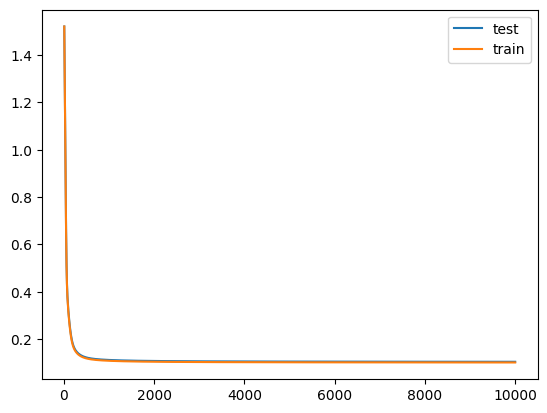

In [ ]:
plotTradeoff(test,train)

**With L1 Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R',regulization_type='L1',alpha=0.01)

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=1000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  1.420905013297960 	################ Test Loss =  1.422546873092241
Epoch number = 20 	################ Train Loss =  1.400424915560545 	################ Test Loss =  1.402327797850582
Epoch number = 30 	################ Train Loss =  1.382914053694297 	################ Test Loss =  1.385042151889986
Epoch number = 40 	################ Train Loss =  1.367456082952412 	################ Test Loss =  1.369786942019819
Epoch number = 50 	################ Train Loss =  1.352483330977235 	################ Test Loss =  1.355027940474071
Epoch number = 60 	################ Train Loss =  1.336957261174898 	################ Test Loss =  1.339747590688338
Epoch number = 70 	################ Train Loss =  1.320280488025326 	################ Test Loss =  1.323359514167578
Epoch number = 80 	################ Train Loss =  1.301425783148357 	################ Test Loss =  1.304849455554727
Epoch number = 90 	################ Train Loss =  1.279730230119

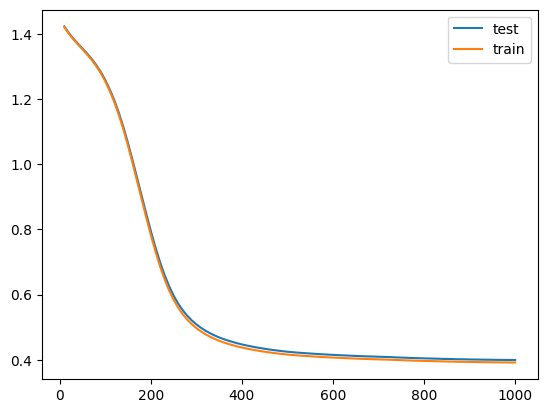

In [ ]:
plotTradeoff(test,train)

**With L2 Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R',regulization_type='L2',alpha=0.01)

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=1000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  1.453111574983654 	################ Test Loss =  1.454044902135151
Epoch number = 20 	################ Train Loss =  1.429089940884087 	################ Test Loss =  1.430435638207356
Epoch number = 30 	################ Train Loss =  1.402644131610286 	################ Test Loss =  1.404458991490796
Epoch number = 40 	################ Train Loss =  1.372496999178014 	################ Test Loss =  1.374864756332025
Epoch number = 50 	################ Train Loss =  1.337534523200303 	################ Test Loss =  1.340562630015004
Epoch number = 60 	################ Train Loss =  1.296856943440237 	################ Test Loss =  1.300670425936485
Epoch number = 70 	################ Train Loss =  1.249819364157959 	################ Test Loss =  1.254551146014959
Epoch number = 80 	################ Train Loss =  1.196072834433854 	################ Test Loss =  1.201850805841989
Epoch number = 90 	################ Train Loss =  1.135652503082

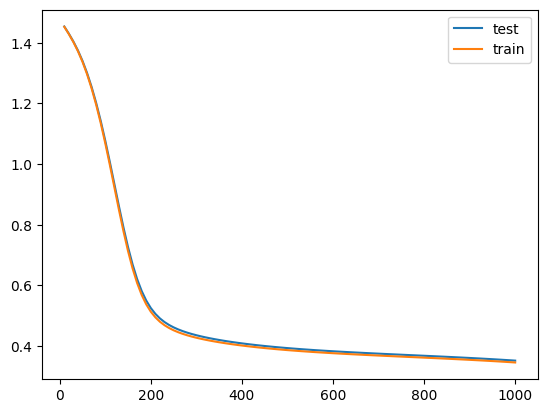

In [ ]:
plotTradeoff(test,train)

**With L1 + L2 Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R',regulization_type='both',alpha=0.01)

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=1000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  1.484799964301366 	################ Test Loss =  1.484960648485910
Epoch number = 20 	################ Train Loss =  1.465501235294934 	################ Test Loss =  1.465928271358691
Epoch number = 30 	################ Train Loss =  1.447658861619389 	################ Test Loss =  1.448335031089166
Epoch number = 40 	################ Train Loss =  1.429011936905744 	################ Test Loss =  1.429959244516781
Epoch number = 50 	################ Train Loss =  1.407587472546679 	################ Test Loss =  1.408866238127303
Epoch number = 60 	################ Train Loss =  1.382104142054037 	################ Test Loss =  1.383804805110167
Epoch number = 70 	################ Train Loss =  1.351504346601548 	################ Test Loss =  1.353745001282807
Epoch number = 80 	################ Train Loss =  1.314952523672397 	################ Test Loss =  1.317873574023622
Epoch number = 90 	################ Train Loss =  1.271884861758

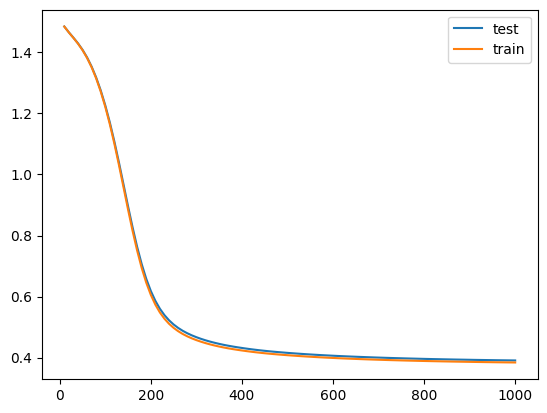

In [ ]:
plotTradeoff(test,train)

**Polynomial Regression**

Performing polynomial regression in four cases: \
1. Setting hyperparameters to overfit the data \
2. Using L1 Regularization \
3. Using L2 Regularization \
3. Using both L1 and L2 Regularization

In [ ]:
data = np.loadtxt('/content/drive/My Drive/PRNN_assignment_1/regression_data_multiGen_group_9_train.txt', delimiter='\t',skiprows=1)

In [ ]:
X_train,y_train,X_test,y_test=splitTrainTest(data,0.8,2)
X_train=normalizeData(X_train)
X_test=normalizeData(X_test)
y_train=normalizeData(y_train)
y_test=normalizeData(y_test)

print(X_train.shape,y_test.shape)

(11200, 2) (2800, 3)


In [ ]:
layer=[2,20,10,3]

**Without Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R')

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=10000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  1.513856668041135 	################ Test Loss =  1.513878581057625
Epoch number = 20 	################ Train Loss =  1.512050311310321 	################ Test Loss =  1.512069568866091
Epoch number = 30 	################ Train Loss =  1.510415687714711 	################ Test Loss =  1.510432529965263
Epoch number = 40 	################ Train Loss =  1.508927839362338 	################ Test Loss =  1.508942474134565
Epoch number = 50 	################ Train Loss =  1.507564819055278 	################ Test Loss =  1.507577425255338
Epoch number = 60 	################ Train Loss =  1.506307113471371 	################ Test Loss =  1.506317843826649
Epoch number = 70 	################ Train Loss =  1.505137164889896 	################ Test Loss =  1.505146148140433
Epoch number = 80 	################ Train Loss =  1.504038967501139 	################ Test Loss =  1.504046310124299
Epoch number = 90 	################ Train Loss =  1.502997719537

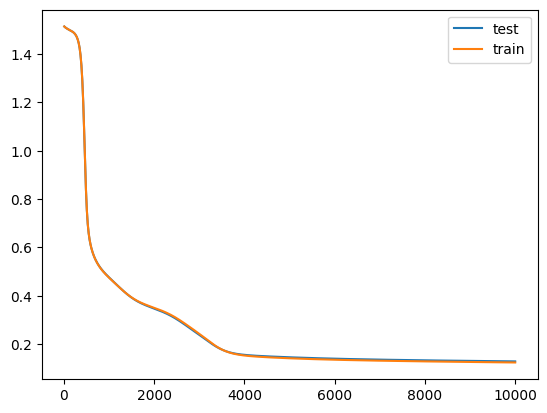

In [ ]:
plotTradeoff(test,train)

**With L1 Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R',regulization_type='L1',alpha=0.01)

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=1000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  1.486985673135383 	################ Test Loss =  1.486879651644218
Epoch number = 20 	################ Train Loss =  1.486988218374567 	################ Test Loss =  1.486886947370054
Epoch number = 30 	################ Train Loss =  1.487234338503224 	################ Test Loss =  1.487138405833251
Epoch number = 40 	################ Train Loss =  1.487712152982779 	################ Test Loss =  1.487622085434120
Epoch number = 50 	################ Train Loss =  1.488363647113938 	################ Test Loss =  1.488280464541040
Epoch number = 60 	################ Train Loss =  1.489262395675636 	################ Test Loss =  1.489187027927528
Epoch number = 70 	################ Train Loss =  1.490163101742581 	################ Test Loss =  1.490095267780182
Epoch number = 80 	################ Train Loss =  1.491095629807074 	################ Test Loss =  1.491035193802379
Epoch number = 90 	################ Train Loss =  1.491998658839

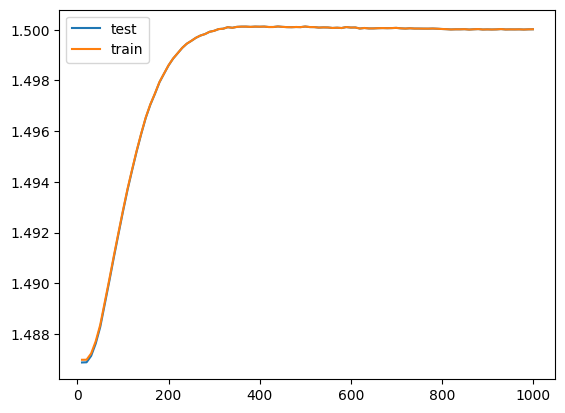

In [ ]:
plotTradeoff(test,train)

**With L2 Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R',regulization_type='L2',alpha=0.01)

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=1000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  1.487049537563530 	################ Test Loss =  1.487112958818219
Epoch number = 20 	################ Train Loss =  1.486291099784283 	################ Test Loss =  1.486353267991904
Epoch number = 30 	################ Train Loss =  1.485501297519560 	################ Test Loss =  1.485562197043071
Epoch number = 40 	################ Train Loss =  1.484677389332093 	################ Test Loss =  1.484736998194839
Epoch number = 50 	################ Train Loss =  1.483816461498294 	################ Test Loss =  1.483874751052184
Epoch number = 60 	################ Train Loss =  1.482915396245046 	################ Test Loss =  1.482972330772089
Epoch number = 70 	################ Train Loss =  1.481970836532235 	################ Test Loss =  1.482026372770865
Epoch number = 80 	################ Train Loss =  1.480979146608308 	################ Test Loss =  1.481033233194084
Epoch number = 90 	################ Train Loss =  1.479936367451

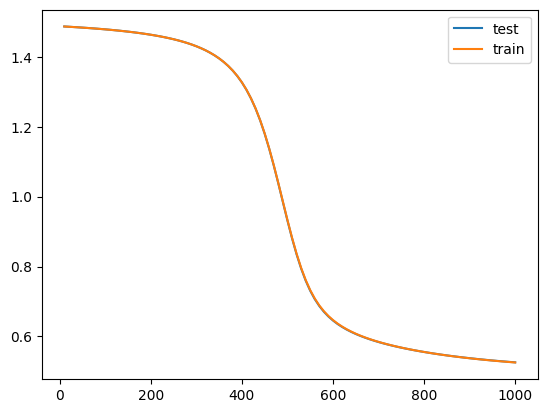

In [ ]:
plotTradeoff(test,train)

**With L1 + L2 Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R',regulization_type='both',alpha=0.01)

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=1000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  1.483438214254432 	################ Test Loss =  1.483429711391748
Epoch number = 20 	################ Train Loss =  1.482910012760476 	################ Test Loss =  1.482900356754127
Epoch number = 30 	################ Train Loss =  1.482412840087837 	################ Test Loss =  1.482402183964376
Epoch number = 40 	################ Train Loss =  1.481927861190736 	################ Test Loss =  1.481916287192863
Epoch number = 50 	################ Train Loss =  1.481482388584123 	################ Test Loss =  1.481470077672589
Epoch number = 60 	################ Train Loss =  1.481052354763720 	################ Test Loss =  1.481039384974632
Epoch number = 70 	################ Train Loss =  1.480640474153280 	################ Test Loss =  1.480626954726165
Epoch number = 80 	################ Train Loss =  1.480232472915291 	################ Test Loss =  1.480218433406126
Epoch number = 90 	################ Train Loss =  1.479868985693

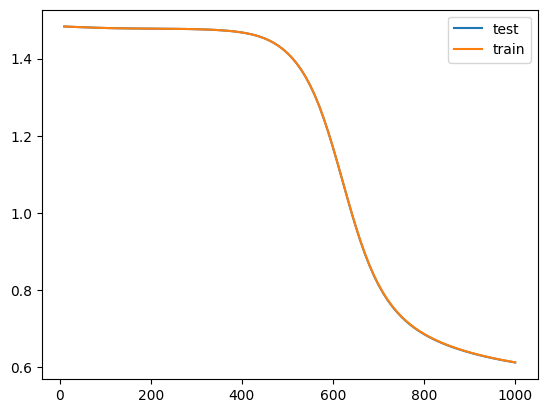

In [ ]:
plotTradeoff(test,train)

**Logistic Regression**

Performing logistic regression in four cases: \
1. Setting hyperparameters to overfit the data \
2. Using L1 Regularization \
3. Using L2 Regularization \
3. Using both L1 and L2 Regularization

In [ ]:
data = np.loadtxt('/content/drive/My Drive/PRNN_assignment_1/regression_data_uni_group_9_train.txt', delimiter='\t',skiprows=1)

In [ ]:
X_train,y_train,X_test,y_test=splitTrainTest(data,0.8,5)
X_train=normalizeData(X_train)
X_test=normalizeData(X_test)
y_train=normalizeData(y_train)
y_test=normalizeData(y_test)

print(X_train.shape,y_test.shape)

(5600, 5) (1400, 1)


In [ ]:
layer=[5,25,1]

**Without Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R')

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=10000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  0.441597868388588 	################ Test Loss =  0.439811804835953
Epoch number = 20 	################ Train Loss =  0.362540058883913 	################ Test Loss =  0.361283436156044
Epoch number = 30 	################ Train Loss =  0.302515601165406 	################ Test Loss =  0.301367601381414
Epoch number = 40 	################ Train Loss =  0.258281377912132 	################ Test Loss =  0.256945497394850
Epoch number = 50 	################ Train Loss =  0.227359177666069 	################ Test Loss =  0.225659595097641
Epoch number = 60 	################ Train Loss =  0.206938910657840 	################ Test Loss =  0.204806780844543
Epoch number = 70 	################ Train Loss =  0.194099896218009 	################ Test Loss =  0.191543485320830
Epoch number = 80 	################ Train Loss =  0.186297728858329 	################ Test Loss =  0.183368657355539
Epoch number = 90 	################ Train Loss =  0.181625548221

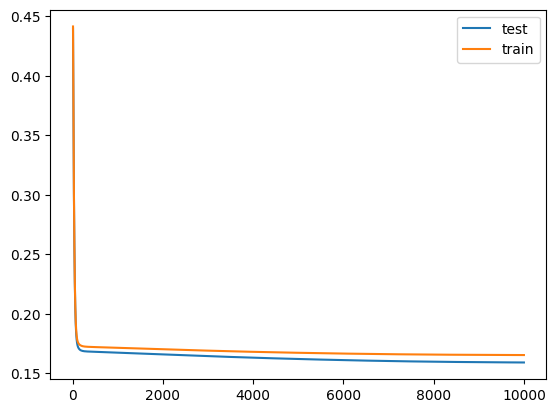

In [ ]:
plotTradeoff(test,train)

**With L1 Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R',regulization_type='L1',alpha=0.01)

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=1000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  0.167902688342663 	################ Test Loss =  0.161694853901603
Epoch number = 20 	################ Train Loss =  0.167845000600239 	################ Test Loss =  0.161618798055698
Epoch number = 30 	################ Train Loss =  0.167841303422966 	################ Test Loss =  0.161614016508697
Epoch number = 40 	################ Train Loss =  0.167859317884534 	################ Test Loss =  0.161641930244595
Epoch number = 50 	################ Train Loss =  0.167815772910268 	################ Test Loss =  0.161589130485658
Epoch number = 60 	################ Train Loss =  0.167807433468818 	################ Test Loss =  0.161577651346655
Epoch number = 70 	################ Train Loss =  0.167793811063520 	################ Test Loss =  0.161562764312499
Epoch number = 80 	################ Train Loss =  0.167780391528790 	################ Test Loss =  0.161549809809118
Epoch number = 90 	################ Train Loss =  0.167791922051

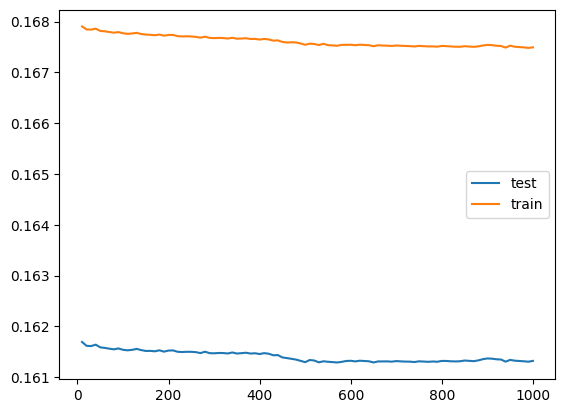

In [ ]:
plotTradeoff(test,train)

**With L2 Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R',regulization_type='L2',alpha=0.01)

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=1000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  0.462634926743962 	################ Test Loss =  0.460476842118084
Epoch number = 20 	################ Train Loss =  0.391177734408269 	################ Test Loss =  0.389664038931209
Epoch number = 30 	################ Train Loss =  0.334359954912257 	################ Test Loss =  0.333138762719368
Epoch number = 40 	################ Train Loss =  0.289481869110556 	################ Test Loss =  0.288281926606486
Epoch number = 50 	################ Train Loss =  0.255186374205820 	################ Test Loss =  0.253812771435364
Epoch number = 60 	################ Train Loss =  0.230072560150042 	################ Test Loss =  0.228409985962597
Epoch number = 70 	################ Train Loss =  0.212419462593200 	################ Test Loss =  0.210423778487073
Epoch number = 80 	################ Train Loss =  0.200405890759896 	################ Test Loss =  0.198084774674285
Epoch number = 90 	################ Train Loss =  0.192394843538

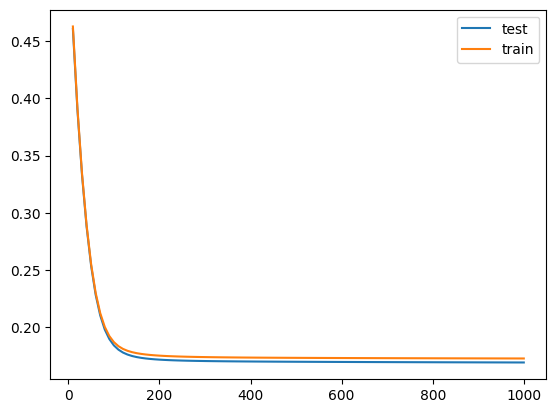

In [ ]:
plotTradeoff(test,train)

**With L1 + L2 Regularization**

In [ ]:
nn=neuralNetwork(layer,output_type='R',regulization_type='both',alpha=0.01)

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=1000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  0.435665833568384 	################ Test Loss =  0.434925695452304
Epoch number = 20 	################ Train Loss =  0.385405143283820 	################ Test Loss =  0.384814193278378
Epoch number = 30 	################ Train Loss =  0.342750505189403 	################ Test Loss =  0.342123347475807
Epoch number = 40 	################ Train Loss =  0.306482126029831 	################ Test Loss =  0.305687116334814
Epoch number = 50 	################ Train Loss =  0.276105388685052 	################ Test Loss =  0.275056183172152
Epoch number = 60 	################ Train Loss =  0.251498082338087 	################ Test Loss =  0.250150264880236
Epoch number = 70 	################ Train Loss =  0.232406520576582 	################ Test Loss =  0.230734675218899
Epoch number = 80 	################ Train Loss =  0.218099545650776 	################ Test Loss =  0.216117063943367
Epoch number = 90 	################ Train Loss =  0.207764974374

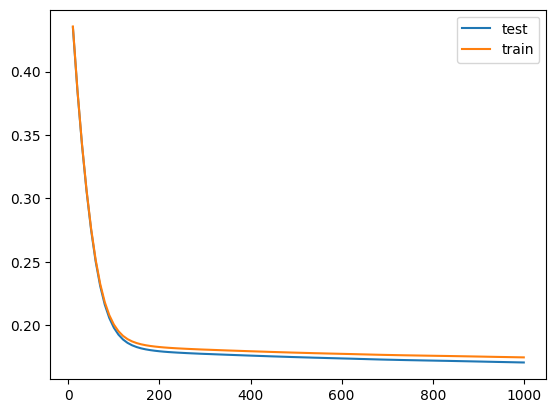

In [ ]:
plotTradeoff(test,train)

#Classification with MLP

**Binary Classification**

Performing Binary classification using two loss functions: \
1. MSE Loss function \
2. Cross entropy function

In [ ]:
data = np.loadtxt('/content/drive/My Drive/PRNN_assignment_1/binary_classification_data_group_9_train.txt', delimiter='\t',skiprows=1)

In [ ]:
X_train,y_train,X_test,y_test=splitTrainTest(data,0.8,10)
X_train=normalizeData(X_train)
X_test=normalizeData(X_test)
y_test=oneHotConvert(y_test,2)
y_train=oneHotConvert(y_train,2)

print(X_train.shape,y_test.shape)

(11200, 10) (2800, 2)


In [ ]:
layer=[10,25,15,2]

With MSE loss function

In [ ]:
nn=neuralNetwork(layer,output_type='c',activation_fun='sigmoid',loss_fun="MSE")

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=5000,test_data=True,X_test=X_test.T,y_test=y_test.T)

(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 2800)
(2, 11200)
-----------------------------------------------------------------------------------------------------------------------------
Epoch number = 10 	################ Train accuracy =  0.609285714285714 	################ Test accuracy =  0.605714285714286
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 2800)
(2, 11200)
-----------------------------------------------------------------------------------------------------------------------------
Epoch number = 20 	################ Train accuracy =  0.610446428571429 	################ Test accuracy =  0.606071428571429
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 11200)
(2, 2800)
(2, 11200)
----------------------------------------------------------------------------------------------

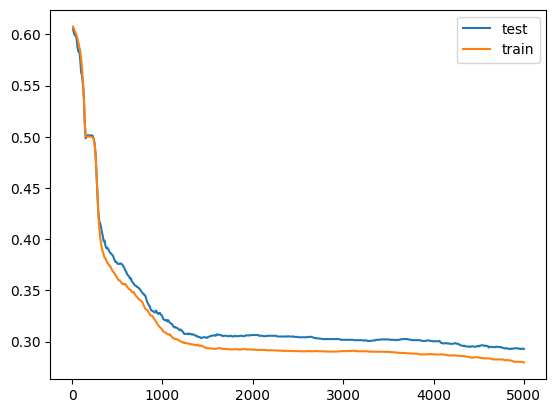

In [ ]:
plotTradeoff(test,train)

With Cross entropy loss function

In [ ]:
nn=neuralNetwork(layer,output_type='c',activation_fun='relu',loss_fun="ce")

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=5000,test_data=True,X_test=X_test.T,y_test=y_test.T)

Epoch number = 10 	################ Train accuracy =  0.621517857142857 	################ Test accuracy =  0.621785714285714
Epoch number = 20 	################ Train accuracy =  0.637321428571429 	################ Test accuracy =  0.637500000000000
Epoch number = 30 	################ Train accuracy =  0.655178571428571 	################ Test accuracy =  0.650357142857143
Epoch number = 40 	################ Train accuracy =  0.669910714285714 	################ Test accuracy =  0.663928571428571
Epoch number = 50 	################ Train accuracy =  0.682946428571429 	################ Test accuracy =  0.671071428571429
Epoch number = 60 	################ Train accuracy =  0.690982142857143 	################ Test accuracy =  0.677142857142857
Epoch number = 70 	################ Train accuracy =  0.696428571428571 	################ Test accuracy =  0.683928571428571
Epoch number = 80 	################ Train accuracy =  0.699821428571429 	################ Test accuracy =  0.691071428571429


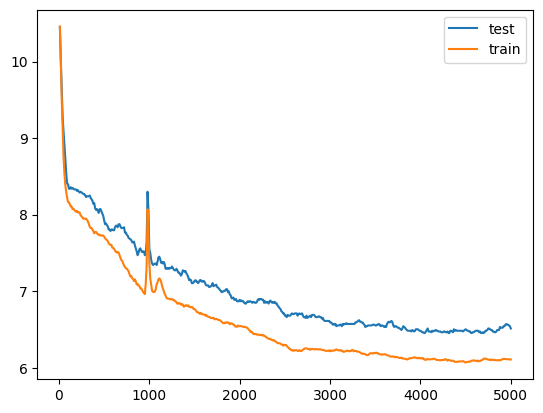

In [ ]:
plotTradeoff(test,train)

**Multiclass classification**

Performing multi-class classification using two loss functions: \
1. MSE Loss function \
2. Cross entropy function \

In [ ]:
data = np.loadtxt('/content/drive/My Drive/PRNN_assignment_1/multi_class_classification_data_group_9_train.txt', delimiter='\t',skiprows=1)

In [ ]:
X_train,y_train,X_test,y_test=splitTrainTest(data,0.8,25)
X_train=normalizeData(X_train)
X_test=normalizeData(X_test)
y_test=oneHotConvert(y_test,10)
y_train=oneHotConvert(y_train,10)

print(X_train.shape,y_test.shape)

(56000, 25) (14000, 10)


In [ ]:
layer=[25,20,15,10]

With MSE loss function

In [ ]:
nn=neuralNetwork(layer,output_type='c',activation_fun='relu',loss_fun="MSE")

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=500,test_data=True,X_test=X_test.T,y_test=y_test.T)

(10, 56000)
(10, 56000)
iteration  number 0
(10, 56000)
iteration  number 1
(10, 56000)
iteration  number 2
(10, 56000)
iteration  number 3
(10, 56000)
iteration  number 4
(10, 56000)
iteration  number 5
(10, 56000)
iteration  number 6
(10, 56000)
iteration  number 7
(10, 56000)
iteration  number 8
(10, 56000)
iteration  number 9
(10, 14000)
(10, 56000)
-----------------------------------------------------------------------------------------------------------------------------
Epoch number = 10 	################ Train accuracy =  0.099107142857143 	################ Test accuracy =  0.101214285714286
(10, 56000)
iteration  number 10
(10, 56000)
iteration  number 11
(10, 56000)
iteration  number 12
(10, 56000)
iteration  number 13
(10, 56000)
iteration  number 14
(10, 56000)
iteration  number 15
(10, 56000)
iteration  number 16
(10, 56000)
iteration  number 17
(10, 56000)
iteration  number 18
(10, 56000)
iteration  number 19
(10, 14000)
(10, 56000)
---------------------------------------

KeyboardInterrupt: 

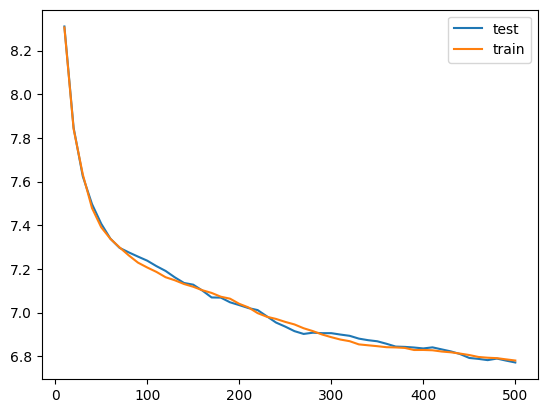

In [ ]:
plotTradeoff(test,train)

With Cross entropy function

In [ ]:
nn=neuralNetwork(layer,output_type='c',activation_fun='relu',loss_fun="ce")

In [ ]:
test,train=nn.train(X_train.T,y_train.T,learning_rate=0.1,iterations=500,test_data=True,X_test=X_test.T,y_test=y_test.T)

(10, 56000)
(10, 56000)
iteration  number 0
(10, 56000)
iteration  number 1
(10, 56000)
iteration  number 2
(10, 56000)
iteration  number 3
(10, 56000)
iteration  number 4
(10, 56000)
iteration  number 5
(10, 56000)
iteration  number 6
(10, 56000)
iteration  number 7
(10, 56000)
iteration  number 8
(10, 56000)
iteration  number 9
(10, 14000)
(10, 56000)
-----------------------------------------------------------------------------------------------------------------------------
Epoch number = 10 	################ Train accuracy =  0.125875000000000 	################ Test accuracy =  0.127000000000000
(10, 56000)
iteration  number 10
(10, 56000)
iteration  number 11
(10, 56000)
iteration  number 12
(10, 56000)
iteration  number 13
(10, 56000)
iteration  number 14
(10, 56000)
iteration  number 15
(10, 56000)
iteration  number 16
(10, 56000)
iteration  number 17
(10, 56000)
iteration  number 18
(10, 56000)
iteration  number 19
(10, 14000)
(10, 56000)
---------------------------------------

KeyboardInterrupt: 

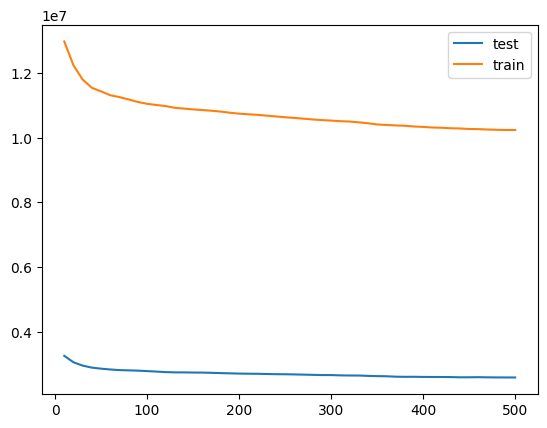

In [ ]:
plotTradeoff(test,train)

#MNIST

**Using MLP with cross entropy as loss function**

In [ ]:
x_train, y_train, x_test, y_test =importMNIST()

(60000, 28, 28)


In [ ]:
# x_train=x_train.flatten()
x_train=x_train.reshape(x_train.shape[0], -1).T
x_test=x_train.reshape(x_test.shape[0], -1).T
y_train=oneHotConvert(y_train,10)
y_test=oneHotConvert(y_test,10)
print(x_train.shape)
print(y_test.shape)

(784, 60000)
(10000, 10)


In [ ]:
layer=[784, 256, 128, 10]

In [ ]:
nn=neuralNetwork(layer,output_type='c',activation_fun='relu',loss_fun="ce")

In [ ]:
test,train=nn.train(x_train,y_train.T,learning_rate=0.1,iterations=500,test_data=True,X_test=x_test,y_test=y_test.T)

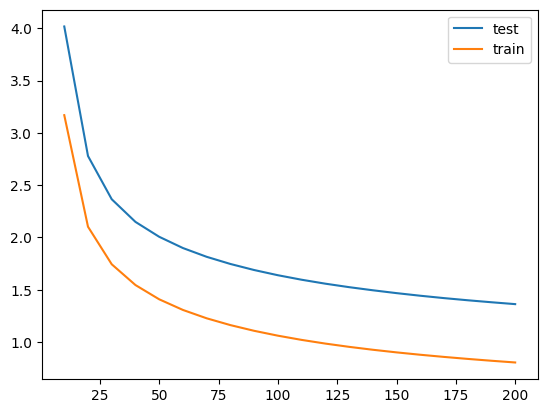

In [ ]:
plotTradeoff(test,train)

**Using MLP with MSE loss function**

In [ ]:
nn=neuralNetwork(layer,output_type='c',activation_fun='relu',loss_fun="MSE")

In [ ]:
test,train=nn.train(x_train,y_train.T,learning_rate=0.1,iterations=500,test_data=True,X_test=x_test,y_test=y_test.T)

Epoch number = 10 	################ Train accuracy =  39.031666666666666 	################ Test accuracy =  29.459999999999997
Epoch number = 20 	################ Train accuracy =  46.686666666666667 	################ Test accuracy =  35.310000000000002
Epoch number = 30 	################ Train accuracy =  51.496666666666670 	################ Test accuracy =  38.629999999999995
Epoch number = 40 	################ Train accuracy =  55.406666666666673 	################ Test accuracy =  41.699999999999996
Epoch number = 50 	################ Train accuracy =  58.408333333333331 	################ Test accuracy =  44.240000000000002
Epoch number = 60 	################ Train accuracy =  60.858333333333334 	################ Test accuracy =  46.509999999999998
Epoch number = 70 	################ Train accuracy =  62.778333333333336 	################ Test accuracy =  48.250000000000000
Epoch number = 80 	################ Train accuracy =  64.351666666666659 	################ Test accuracy =  49.

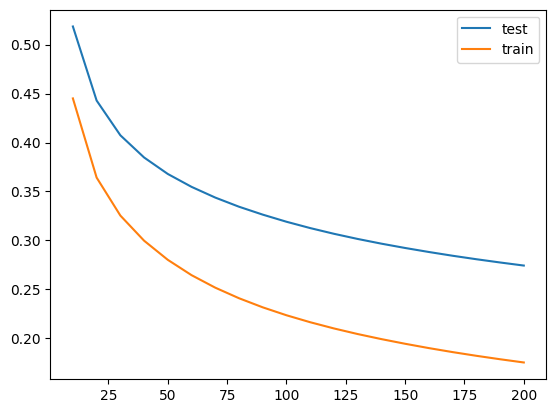

In [ ]:
plotTradeoff(test,train)

**Using Logistic Regression**

In [ ]:
layer=[784,10]
nn=neuralNetwork(layer,output_type='l',activation_fun='sigmoid',loss_fun="MSE")
test,train=nn.train(x_train,y_train.T,learning_rate=0.1,iterations=200,test_data=True,X_test=x_test,y_test=y_test.T)

Epoch number = 10 	################ Train Loss =  3.387058063417999 	################ Test Loss =  3.387058063417999
Epoch number = 20 	################ Train Loss =  2.318536153980814 	################ Test Loss =  2.318536153980814
Epoch number = 30 	################ Train Loss =  1.872592315518563 	################ Test Loss =  1.872592315518563
Epoch number = 40 	################ Train Loss =  1.623068660437018 	################ Test Loss =  1.623068660437018
Epoch number = 50 	################ Train Loss =  1.461318465276299 	################ Test Loss =  1.461318465276299
Epoch number = 60 	################ Train Loss =  1.344515552337602 	################ Test Loss =  1.344515552337602
Epoch number = 70 	################ Train Loss =  1.254315403581386 	################ Test Loss =  1.254315403581386
Epoch number = 80 	################ Train Loss =  1.181364419755914 	################ Test Loss =  1.181364419755914
Epoch number = 90 	################ Train Loss =  1.120338042934

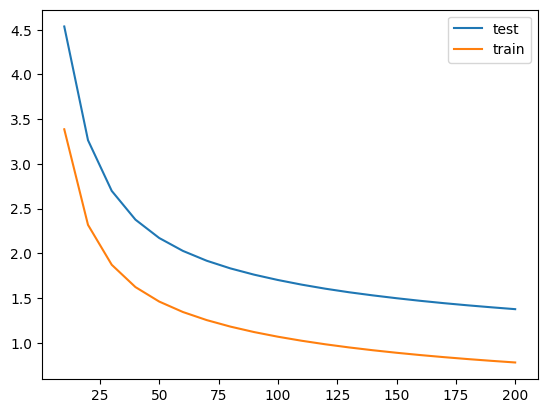

In [ ]:
plotTradeoff(test,train)